# Import libraries

In [1]:
#using KernelEstimator
using Distributions
using LinearAlgebra
using KernelDensity
using MultiKDE
using Plots
using Optim
using DataFrames
using Statistics
using BlockArrays
using Shuffle
using Random
using ScikitLearn
@sk_import covariance : LedoitWolf

PyObject <class 'sklearn.covariance._shrunk_covariance.LedoitWolf'>

# Include jl file

In [2]:
include("Denoising_Jl.jl")

optPort

# TESTING THE MARCENKO–PASTUR THEOREM

In [211]:
# Random Matrix
X = rand(Normal(0, 1), 10000, 1000)
# Get the eigenvalues and vectors of the correlation matrix of X
eVal0, eVec0 = PCA(cor(X))
# Marcenko-Pastur pdf
pdf0 = pdfMarcenkoPastur(1., size(X)[1]/size(X)[2], 1000)
# Fits a Kernel Density Estimate to the eigenvalues of the correlation matrix
pdf1 = KDE(diag(eVal0), bandWidth = 0.01, kernel = Distributions.Normal, valuesForEvaluating = nothing);

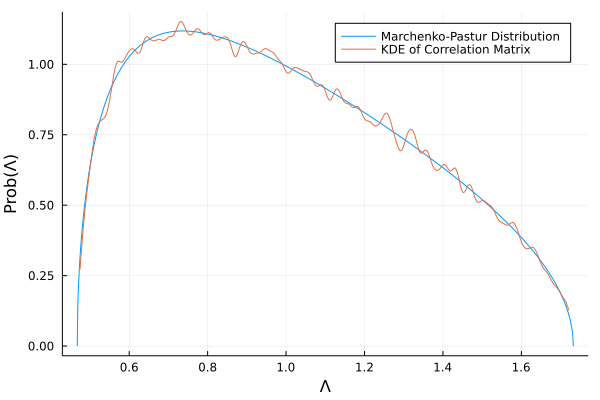

In [212]:
plot(pdf0.index,pdf0.values,label="Marchenko-Pastur Distribution")
plot!(pdf1.index,pdf1.values,label="KDE of Correlation Matrix")
xlabel!("Λ")
ylabel!("Prob(Λ)")

# ADD SIGNAL TO A RANDOM COVARIANCE MATRIX

In [213]:
alpha, numberColumns, numberFactors, ratio = .995, 1000, 100, 10
covv = cov(rand(Normal(0,1),numberColumns*ratio,numberColumns))
covv = alpha*covv + (1 - alpha)*randomCov(numberColumns, numberFactors) # noise+signal
corr0 = covToCorr(covv)
eval0, evec0 = PCA(corr0);

# FITTING THE MARCENKO–PASTUR PDF

In [216]:
emax0, var0 = findMaxEval(diag(eval0), ratio, .01)
numberFactors0 = size(eval0)[1] - searchsortedfirst(reverse(diag(eval0)), emax0) + 1

100

# Denoising

## Constant Residual Eigenvalue Method

In [217]:
corr1 = denoisedCorr(eval0, evec0, numberFactors0)
eval1 , evec1 = PCA(corr1);

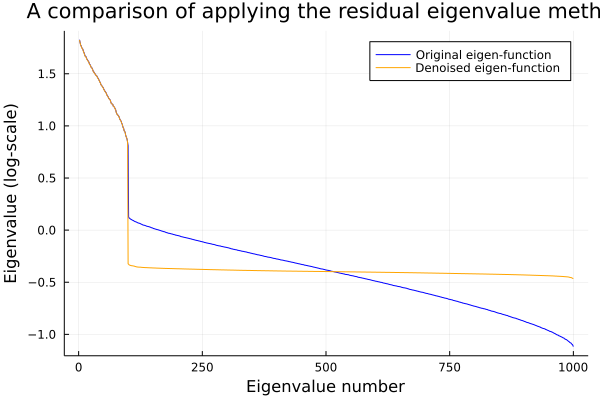

In [218]:
plot(log.(diag(eval0)), c = :blue, title = "A comparison of applying the residual eigenvalue method",
     label = "Original eigen-function")
plot!(log.(diag(eval1)), c = :orange, label = "Denoised eigen-function")
xlabel!("Eigenvalue number")
ylabel!("Eigenvalue (log-scale)")

# Detoning

# DENOISING BY TARGETED SHRINKAG

In [219]:
corr1 = denoisedCorrShrinkage(eval0, evec0, numberFactors0, α = .5)
eval1 , evec1 = PCA(corr1);

# GENERATING A BLOCK-DIAGONAL COVARIANCE MATRIX AND A VECTOR OF MEANS

In [3]:
nblocks, bsize, bcorr = 10, 50, .5
mu0, cov0 = formTrueMatrix(nblocks, bsize, bcorr);

# DENOISING OF THE EMPIRICAL COVARIANCE MATRIX

 # Minimum Variance Portfolio

In [227]:
nObs, ntrials, bWidth, shrink, minVarPortf = 100, 100, .01 , false, true
w1 = DataFrames.DataFrame(zeros(ntrials, size(cov0)[1]), :auto)
DataFrames.rename!(w1, names(w1).=>Symbol.(range(1,stop = 500)))
w1_d = copy(w1)
Random.seed!(0)
for i in 1:ntrials
    mu1, cov1 = simCovMu(vcat(mu0...), cov0, nObs, shrink)
    if minVarPortf 
        mu1 = nothing
    end
    cov1_d = deNoiseCov(cov1, nObs/size(cov1)[1], bWidth)
    w1[i, :] = optPort(cov1, mu1)
    w1_d[i, :] = optPort(cov1_d, mu1)
end
first(w1, 10)

,1,2,3,4,5,6,7
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.547641,0.233609,-0.0140187,0.156807,0.593732,-0.523792,-0.824615
2,-0.115171,-0.017493,-0.127766,-0.189062,-0.0357991,-0.0805512,-0.151165
3,-0.161525,0.151868,0.0434387,0.00224525,0.107927,-0.103817,-0.351966
4,-0.00206092,-0.0603976,-0.0123934,0.0533413,0.0316566,0.059435,-0.0783134
5,-0.410947,0.0661908,0.313192,-0.750635,0.368717,-0.147931,2.03719
6,-0.121,-0.117699,-0.0843066,-0.297022,0.118221,-0.203473,0.203446
7,0.0308381,0.0357885,-0.0504838,-0.00746016,-0.0442651,-0.197328,0.0161785
8,-0.048759,-0.0362143,-0.000704413,-0.214648,0.0333413,0.0620503,0.098173
9,0.00859115,-0.011228,-0.0361934,-0.0364409,0.0619451,0.0696679,-0.0399642


# ROOT-MEAN-SQUARE ERRORS

In [231]:
if minVarPortf
    inp = nothing 
else 
    inp = mu0
end
w0 = optPort(cov0, inp)
w0 = repeat(transpose(w0), size(w1)[1])
rmsd = mean((Matrix(w1) .- w0).^2)^.5 # RMSE
rmsd_d = mean((Matrix(w1_d) .- w0).^2)^.5 # RMSE
println(rmsd)
println(rmsd_d)

6.288614348639493
0.0030669519145545337


# Maximum Sharpe Ratio Portfolio

In [4]:
nObs, ntrials, bWidth, shrink, minVarPortf = 100, 100, .01 , false, false
w1 = DataFrames.DataFrame(zeros(ntrials, size(cov0)[1]), :auto)
DataFrames.rename!(w1, names(w1).=>Symbol.(range(1,stop = 500)))
w1_d = copy(w1)
Random.seed!(0)
for i in 1:ntrials
    mu1, cov1 = simCovMu(vcat(mu0...), cov0, nObs, shrink)
    if minVarPortf 
        mu1 = nothing
    end
    cov1_d = deNoiseCov(cov1, nObs/size(cov1)[1], bWidth)
    w1[i, :] = optPort(cov1, mu1)
    w1_d[i, :] = optPort(cov1_d, mu1)
end
first(w1, 10)

,1,2,3,4,5,6,7
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0847291,0.0347592,-0.161171,-0.108052,-0.177404,-0.0053757,-0.0325471
2,-0.0806451,-0.0281322,-0.139178,-0.0839771,0.012847,0.0248267,-0.0526193
3,-0.0744791,0.309337,-0.0435755,0.0921864,-0.0551173,0.0175959,0.0141038
4,-0.103591,-0.0606141,0.0464636,0.0911097,-0.0346608,0.0413015,0.110301
5,0.045906,0.0814164,-0.122172,0.035129,0.0105714,0.0113421,0.00937435
6,-0.440367,-0.160718,-0.181276,-0.523326,-0.129204,0.200081,0.126285
7,0.635985,0.402882,0.498909,0.00292255,0.0249705,0.117858,0.110256
8,0.176658,-0.0186975,0.0692255,0.000340319,0.0274117,-0.102726,-0.0190685
9,-0.0689157,-0.011704,0.0551048,0.0597599,0.027052,0.0266576,0.000255284


# ROOT-MEAN-SQUARE ERRORS

In [8]:
if minVarPortf
    inp = nothing 
else 
    inp = vcat(mu0...)
end
w0 = optPort(cov0, inp)
w0 = repeat(transpose(w0), size(w1)[1])
rmsd = mean((Matrix(w1) .- w0).^2)^.5 # RMSE
rmsd_d = mean((Matrix(w1_d) .- w0).^2)^.5 # RMSE
println(rmsd)
println(rmsd_d)

0.5486839848678384
0.18280476877727614
